# Fashion-MNIST Classification with Deep Learning

In this project we use a Convolutional Neural Network (CNN) to classify clothing images from the **Fashion-MNIST** dataset.

We will go through:

1. Problem definition and goals  
2. Exploratory Data Analysis (EDA)  
3. Data preprocessing  
4. Deep learning model design and training  
5. Evaluation and model analysis (metrics, confusion matrix, error analysis)  
6. Discussion and conclusion


In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  # if not installed: pip install seaborn

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)


2.19.0


## 1. Problem Definition

We are given grayscale images (28×28) of clothing items from 10 categories such as T-shirt, trousers, dress, and sneakers.  
The task is to build a deep learning model that:

- Learns to classify each image into one of 10 classes  
- Generalizes well to unseen test images  

This is a **multi-class image classification** problem.

We will use the **Fashion-MNIST** dataset provided by Keras, which contains:

- 60,000 training images  
- 10,000 test images  
- 10 classes


In [10]:
# Load Fashion-MNIST from Keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

## 2. Exploratory Data Analysis (EDA)

We will explore:

- Dataset dimensions and basic statistics  
- Distribution of classes  
- Example images from each class  
- Pixel intensity statistics


Training set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


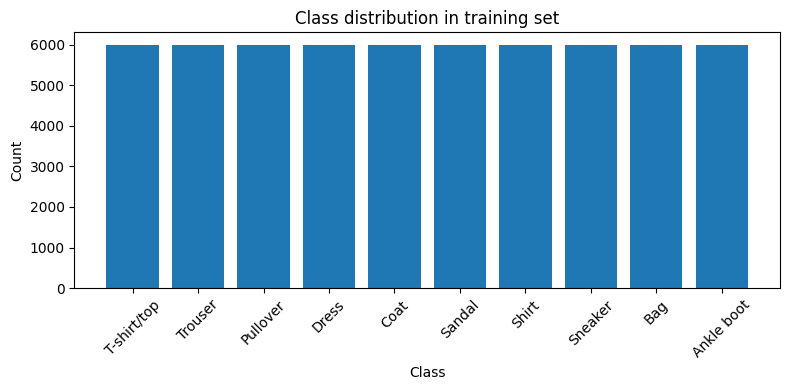

In [11]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# Unique classes
unique_classes, counts = np.unique(y_train, return_counts=True)
print("Classes:", unique_classes)
print("Counts:", counts)

# Plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, counts)
plt.xticks(unique_classes, class_names, rotation=45)
plt.title("Class distribution in training set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


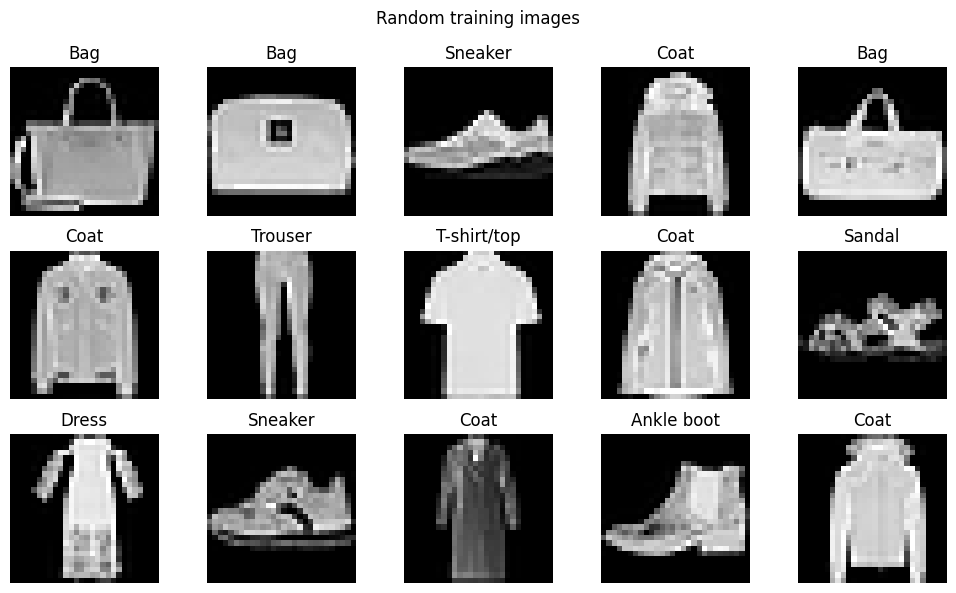

In [12]:
# Show some random images from the training set
num_rows, num_cols = 3, 5
plt.figure(figsize=(10, 6))

indices = np.random.choice(len(X_train), num_rows * num_cols, replace=False)

for i, idx in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[idx], cmap="gray")
    plt.title(class_names[y_train[idx]])
    plt.axis("off")

plt.suptitle("Random training images")
plt.tight_layout()
plt.show()


Pixel value range before scaling: 0 to 255


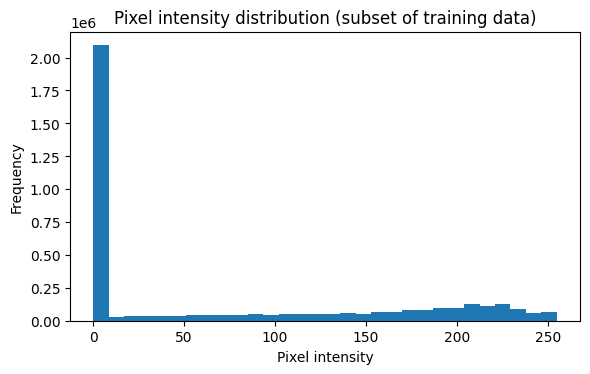

In [13]:
print("Pixel value range before scaling:", X_train.min(), "to", X_train.max())

# Plot histogram of pixel values for a subset
sample = X_train[:5000].reshape(-1)
plt.figure(figsize=(6, 4))
plt.hist(sample, bins=30)
plt.title("Pixel intensity distribution (subset of training data)")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 3. Data Preprocessing

Typical preprocessing steps:

- Scale pixel values to [0, 1] by dividing by 255  
- Reshape images to add channel dimension (required by CNNs)  
- Optionally split some training data into a validation set  
- One-hot encode labels (Keras can also handle integer labels directly when using `sparse_categorical_crossentropy`)


In [14]:
# Scale to [0, 1]
X_train_scaled = X_train.astype("float32") / 255.0
X_test_scaled = X_test.astype("float32") / 255.0

# Add channel dimension: (N, 28, 28, 1)
X_train_scaled = np.expand_dims(X_train_scaled, -1)
X_test_scaled = np.expand_dims(X_test_scaled, -1)

X_train_scaled.shape, X_test_scaled.shape


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [15]:
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.1, random_state=42, stratify=y_train
)

X_train_final.shape, X_val.shape, y_train_final.shape, y_val.shape


((54000, 28, 28, 1), (6000, 28, 28, 1), (54000,), (6000,))

## 4. Deep Learning Model Design

We will use a Convolutional Neural Network (CNN) with the following structure:

- Input: 28×28×1 images  
- Convolution + ReLU + MaxPooling layers to learn spatial features  
- Dropout to reduce overfitting  
- Dense layers for classification  
- Output: 10 units with softmax activation

Loss: `sparse_categorical_crossentropy`  
Optimizer: Adam  
Metrics: accuracy


In [16]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

We will train the model with:

- Batch size: 64  
- Epochs: 10–15 (you can experiment)  
- Validation data: 10% of training data held out earlier  

We will also track the training and validation loss/accuracy curves.


In [ ]:
batch_size = 64
epochs = 12

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs
)


Epoch 1/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.6465 - loss: 0.9526 - val_accuracy: 0.8525 - val_loss: 0.4034
Epoch 2/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.8403 - loss: 0.4378 - val_accuracy: 0.8825 - val_loss: 0.3200
Epoch 3/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.8673 - loss: 0.3652 - val_accuracy: 0.8947 - val_loss: 0.2865
Epoch 4/12


In [ ]:
history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train acc")
plt.plot(epochs_range, val_acc, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train loss")
plt.plot(epochs_range, val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()

plt.tight_layout()
plt.show()


## 6. Model Evaluation and Analysis

We now evaluate the trained model on the test set and analyze:

- Overall accuracy  
- Per-class performance using classification report  
- Confusion matrix  
- Visual inspection of some correct and misclassified examples


In [ ]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
misclassified_indices = np.where(y_pred != y_test)[0]
len(misclassified_indices)


In [ ]:
# Show some misclassified images
num_examples = 15
indices = np.random.choice(misclassified_indices, size=min(num_examples, len(misclassified_indices)), replace=False)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[idx], cmap="gray")
    plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis("off")

plt.suptitle("Sample misclassified images")
plt.tight_layout()
plt.show()


## 7. Discussion

**Overall performance**

- The test accuracy indicates how well the CNN generalizes to unseen images.
- If accuracy is high (for example, above 0.9), the model is performing well on this dataset.

**Training dynamics**

- Compare training vs. validation accuracy and loss curves:
  - If training accuracy is much higher than validation accuracy and the validation loss starts increasing while training loss continues decreasing, the model may be overfitting.
  - If both training and validation curves improve steadily and plateau close to each other, the model is well-regularized.

**Per-class behavior**

- The classification report shows precision, recall, and F1-score for each class.
  - Lower recall for a class means many true images of that class are being misclassified.
  - Lower precision means many predicted images of that class actually belong to other classes.
- The confusion matrix highlights which pairs of classes are most often confused (for example, `Shirt` vs `T-shirt/top`).

**Error analysis**

- The misclassified examples help us see that:
  - Some classes are visually similar (e.g., shirts vs T-shirts, coats vs pullovers).
  - Some images may be ambiguous even for humans.

**Possible improvements**

- Add data augmentation (random rotations, shifts, flips) to increase robustness.
- Adjust model capacity (more or fewer convolutional layers, different number of filters).
- Tune regularization (Dropout rate, L2 weight decay).
- Train for more epochs with early stopping based on validation loss.
- Use more advanced architectures (e.g., ResNet-like blocks).

Overall, this deep learning approach successfully learns useful visual representations and achieves strong performance on the Fashion-MNIST classification task.


## 8. Conclusion

In this project we:

1. Defined a real-world style image classification problem using Fashion-MNIST.  
2. Performed EDA to understand the data distribution and visualize examples.  
3. Preprocessed the data (scaling and reshaping).  
4. Built and trained a CNN with convolution, pooling, and dense layers.  
5. Evaluated the model using accuracy, classification report, and confusion matrix.  
6. Performed error analysis on misclassified examples.  

This notebook can serve as a template for:

- Applying deep learning to other image datasets  
- Structuring an end-to-end workflow with EDA, modeling, and analysis  
- Experimenting with model architectures and regularization strategies
